In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rowan
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy import integrate
import sys
sys.path.append("../")
from utils import calc_quat_angle_error_single, calc_rel_orientation

In [2]:
train_data = pd.read_csv(f'D:/Imperial/FYP/captured_data/airsim_drone_mode/building_new/train/airsim_rec.txt', sep="\t")
test_data = pd.read_csv(f'D:/Imperial/FYP/captured_data/airsim_drone_mode/building_new/val/airsim_rec.txt', sep="\t")

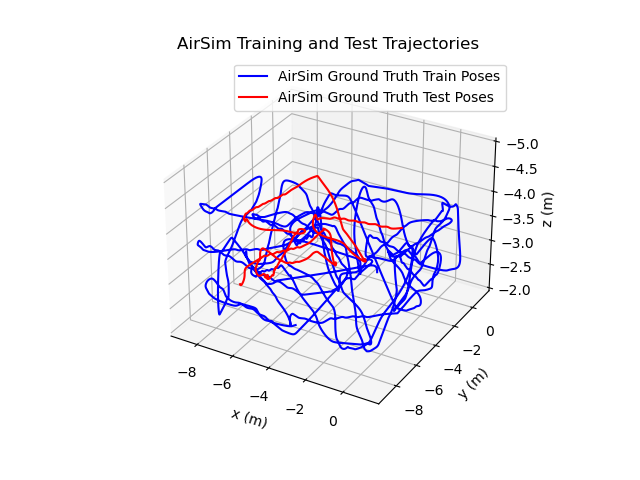

In [3]:
%matplotlib ipympl
plt.figure()
ax = plt.axes(projection= '3d')
ax.plot3D(train_data["POS_X"], train_data["POS_Y"], train_data["POS_Z"], label = "AirSim Ground Truth Train Poses", color = 'blue')
ax.plot3D(test_data["POS_X"], test_data["POS_Y"], test_data["POS_Z"], label = "AirSim Ground Truth Test Poses", color = 'red')
ax.set_zlim([-2, -5])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("AirSim Training and Test Trajectories")
ax.legend()
plt.show()

In [ ]:
%matplotlib inline 

## Distributions

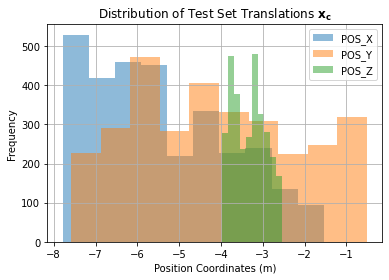

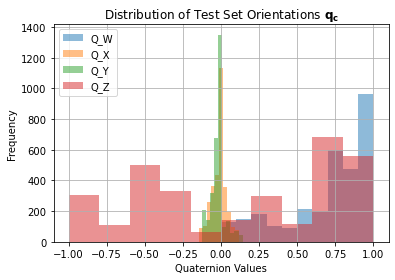

In [9]:
dataset = test_data 
plt.figure()
plt.hist(dataset["POS_X"], label="POS_X", alpha=0.5)
plt.hist(dataset["POS_Y"], label="POS_Y", alpha=0.5)
plt.hist(dataset["POS_Z"], label="POS_Z", alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("Position Coordinates (m)")
plt.title('Distribution of Test Set Translations ' + r'$\bf{x}_c$')
plt.legend()
plt.grid()

plt.figure()
plt.hist(dataset["Q_W"], label="Q_W", alpha=0.5)
plt.hist(dataset["Q_X"], label="Q_X", alpha=0.5)
plt.hist(dataset["Q_Y"], label="Q_Y", alpha=0.5)
plt.hist(dataset["Q_Z"], label="Q_Z", alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("Quaternion Values")
plt.title('Distribution of Test Set Orientations ' + r'$\bf{q}_c$')
plt.legend()
plt.grid()

## Prepare Data for IMU relative pose calculation

In [3]:
# Calculate timestamp, time from start in seconds, and timestep between imu recordings
train_data["timestamp"] = pd.to_datetime(train_data["timestamp"], unit='ns')
train_data["seconds"] = (train_data["timestamp"] - train_data["timestamp"][0]).dt.total_seconds()
train_data["prev_timestamp"] = train_data["timestamp"].shift(1)
train_data["timestep"] = ((train_data["timestamp"] - train_data["prev_timestamp"]).dt.total_seconds())


# Get previous angular velocity
train_data["prev_S_ANG_VEL_X"] = train_data["S_ANG_VEL_X"].shift(1)
train_data["prev_S_ANG_VEL_Y"] = train_data["S_ANG_VEL_Y"].shift(1)
train_data["prev_S_ANG_VEL_Z"] = train_data["S_ANG_VEL_Z"].shift(1)

## Handling IMU

In [4]:
np.random.seed(123)

In [5]:
mode = 2
if mode == 0:
    noise_x = 0
    noise_y = 0
    noise_z = 0
elif mode == 1:
    noise_x = np.random.normal(0,0.5,len(train_data))
    noise_y = np.random.normal(0,0.5,len(train_data))
    noise_z = np.random.normal(0,0.1,len(train_data))
elif mode == 2:     
    noise_x = np.random.normal(0,0.8,len(train_data))
    noise_y = np.random.normal(0,0.8,len(train_data))
    noise_z = np.random.normal(0,0.2,len(train_data))
# elif mode == 3:     
#     noise_x = np.random.normal(0,1,len(train_data))
#     noise_y = np.random.normal(0,1,len(train_data))
#     noise_z = np.random.normal(0,0.3,len(train_data))
train_data["noisy_POS_X"] = noise_x + train_data["POS_X"]
train_data["noisy_POS_Y"] = noise_y + train_data["POS_Y"]
train_data["noisy_POS_Z"] = noise_z + train_data["POS_Z"]

train_data["noisy_prev_POS_X"] = train_data["noisy_POS_X"].shift(1)
train_data["noisy_prev_POS_Y"] = train_data["noisy_POS_Y"].shift(1)
train_data["noisy_prev_POS_Z"] = train_data["noisy_POS_Z"].shift(1)

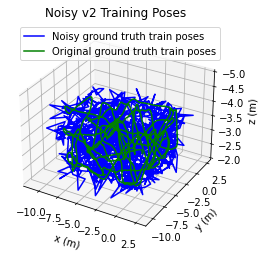

In [6]:
plt.figure()
start=0
step = 10
ax = plt.axes(projection= '3d')
ax.plot3D(train_data["noisy_POS_X"].iloc[start::step], train_data["noisy_POS_Y"].iloc[start::step], train_data["noisy_POS_Z"].iloc[start::step], label = "Noisy ground truth train poses", color = 'blue')
ax.plot3D(train_data["POS_X"].iloc[start::step], train_data["POS_Y"].iloc[start::step], train_data["POS_Z"].iloc[start::step], label = "Original ground truth train poses", color = 'Green')
ax.set_zlim([-2, -5])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("Noisy v2 Training Poses")
ax.legend()
plt.show()

In [7]:
# if mode == 0:
#     noise_qw = 0
#     noise_qx = 0
#     noise_qy = 0
#     noise_qz = 0
# elif mode == 1:
#     noise_qw = np.random.normal(0,0.01,len(train_data))
#     noise_qx = np.random.normal(0,0.01,len(train_data))
#     noise_qy = np.random.normal(0,0.01,len(train_data))
#     noise_qz = np.random.normal(0,0.01,len(train_data))
# elif mode == 2:     
#     noise_qw = np.random.normal(0,0.02,len(train_data))
#     noise_qx = np.random.normal(0,0.02,len(train_data))
#     noise_qy = np.random.normal(0,0.02,len(train_data))
#     noise_qz = np.random.normal(0,0.02,len(train_data))
# elif mode == 3:     
#     noise_qw = np.random.normal(0,0.03,len(train_data))
#     noise_qx = np.random.normal(0,0.03,len(train_data))
#     noise_qy = np.random.normal(0,0.03,len(train_data))
#     noise_qz = np.random.normal(0,0.03,len(train_data))
if mode == 0:
    noise_qw = 0
    noise_qx = 0
    noise_qy = 0
    noise_qz = 0
elif mode == 1:
    noise_qw = np.random.normal(0,0.03,len(train_data))
    noise_qx = np.random.normal(0,0.03,len(train_data))
    noise_qy = np.random.normal(0,0.03,len(train_data))
    noise_qz = np.random.normal(0,0.03,len(train_data))
elif mode == 2:     
    noise_qw = np.random.normal(0,0.05,len(train_data))
    noise_qx = np.random.normal(0,0.05,len(train_data))
    noise_qy = np.random.normal(0,0.05,len(train_data))
    noise_qz = np.random.normal(0,0.05,len(train_data))
train_data["noisy_Q_W"] = noise_qw + train_data["Q_W"]
train_data["noisy_Q_X"] = noise_qx + train_data["Q_X"]
train_data["noisy_Q_Y"] = noise_qy + train_data["Q_Y"]
train_data["noisy_Q_Z"] = noise_qz + train_data["Q_Z"]

# Ensure that noisy quaternions is a valid rotation
normalized_q = pd.DataFrame(rowan.normalize(train_data[["noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z"]]), columns=["noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z"])
train_data["noisy_Q_W"] = normalized_q["noisy_Q_W"]
train_data["noisy_Q_X"] = normalized_q["noisy_Q_X"]
train_data["noisy_Q_Y"] = normalized_q["noisy_Q_Y"]
train_data["noisy_Q_Z"] = normalized_q["noisy_Q_Z"]

train_data["noisy_prev_Q_W"] = train_data["noisy_Q_W"].shift(1)
train_data["noisy_prev_Q_X"] = train_data["noisy_Q_X"].shift(1)
train_data["noisy_prev_Q_Y"] = train_data["noisy_Q_Y"].shift(1)
train_data["noisy_prev_Q_Z"] = train_data["noisy_Q_Z"].shift(1)

### Check Absolute Error after noise injection

In [8]:
err =[]
for idx, row, in train_data.iterrows():
    err.append(np.linalg.norm(np.array(row[["noisy_POS_X", "noisy_POS_Y", "noisy_POS_Z"]]) - np.array(row[["POS_X", "POS_Y", "POS_Z"]])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

q_err = train_data.apply(lambda row: 
                        calc_quat_angle_error_single(
                            np.hstack([row["noisy_Q_W"], row["noisy_Q_X"], row["noisy_Q_Y"], row["noisy_Q_Z"]]),
                            np.hstack([row["Q_W"], row["Q_X"], row["Q_Y"], row["Q_Z"]])
                        ), axis=1)
print(f'Orientation error {np.median(q_err)} (median) deg, {np.mean(q_err)} (mean) deg')

Translation error 0.9625593465084418 (median) m, 1.0262450765430584 (mean) m
Orientation error 8.812923113937975 (median) deg, 9.161756110016253 (mean) deg


### Convert linear acceleration to world coordinate frame

In [9]:
from ahrs.filters import AngularRate
qw = train_data.iloc[0, :].noisy_Q_W
qx = train_data.iloc[0, :].noisy_Q_X
qy = train_data.iloc[0, :].noisy_Q_Y
qz = train_data.iloc[0, :].noisy_Q_Z
cur_q = np.array([qw, qx, qy, qz])
abs_results = [cur_q]
angular_rate = AngularRate()
for j in range(1, len(train_data)):
    row = train_data.iloc[j, :]
    cur_q = angular_rate.update(cur_q, 
                                np.hstack([row["prev_S_ANG_VEL_X"],
                                            row["prev_S_ANG_VEL_Y"], 
                                            row["prev_S_ANG_VEL_Z"]]),
                                'series', 
                                1,
                                row['timestep'])
    norm_q = cur_q
    if norm_q[0] < 0:
        norm_q = -norm_q
    abs_results.append(norm_q)
imu_q_ahrs = pd.DataFrame(abs_results, columns=["pure_imu_Q_W", "pure_imu_Q_X", "pure_imu_Q_Y", "pure_imu_Q_Z"])


<AxesSubplot:>

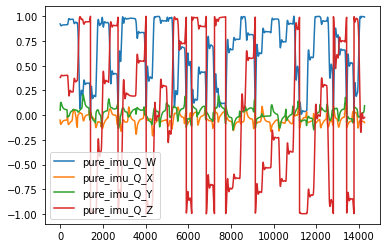

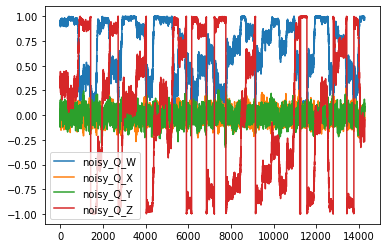

In [10]:
imu_q_ahrs.plot()
train_data[["noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z"]].plot()

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline 

In [ ]:
from scipy import signal
check_data = pd.concat([train_data, imu_q_ahrs], axis=1)
def convert_body_to_world(row):
    body_acc = np.hstack([row["S_LIN_ACC_X"], row["S_LIN_ACC_Y"], row["S_LIN_ACC_Z"]]).astype(float)
    r = R.from_quat(np.hstack([row["pure_imu_Q_X"], row["pure_imu_Q_Y"], row["pure_imu_Q_Z"], row["pure_imu_Q_W"]]))
    world_acc = r.apply(body_acc)
    return world_acc - np.array([0, 0, -9.81])

# Convert imu linear acceleration from body frame to world frame
check_data["S_LIN_ACC_X_world"] = check_data.apply(lambda row : convert_body_to_world(row)[0], axis = 1)
check_data["S_LIN_ACC_Y_world"] = check_data.apply(lambda row : convert_body_to_world(row)[1], axis = 1)
check_data["S_LIN_ACC_Z_world"] = check_data.apply(lambda row : convert_body_to_world(row)[2], axis = 1)

plt.figure(figsize=(8,6))
t = check_data["seconds"]

vel_x = integrate.cumtrapz(check_data["S_LIN_ACC_X_world"], t, initial=0)
vel_y = integrate.cumtrapz(check_data["S_LIN_ACC_Y_world"], t, initial=0)
vel_z = integrate.cumtrapz(check_data["S_LIN_ACC_Z_world"], t, initial=0) 
plt.plot(t, vel_x, label = "velocity_x")
plt.plot(t, signal.detrend(vel_x), label = "velocity_x_detrended")
plt.plot(t, check_data["LIN_VEL_X"], label = "gt_velocity_x")
plt.title("Velocity integrated from acceleration")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
# plt.xlim([50, 160])
# plt.grid()
plt.legend()

plt.figure(figsize=(8,6))
plt.plot(t, integrate.cumtrapz(vel_x, t, initial=0) +  check_data["POS_X"][0], label = "position_x")
plt.plot(t, integrate.cumtrapz(signal.detrend(vel_x), t, initial=0) + check_data["POS_X"][0], label = "position_x_from_detrended_velocity")
plt.plot(t,check_data["POS_X"], label = "gt_position_x")
plt.title("Position double integrated from acceleration")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()

In [ ]:
plt.figure(figsize=(8,6))
# plt.plot(t, integrate.cumtrapz(vel_y, t, initial=0) +  check_data["POS_Y"][0], label = "position_y")
plt.plot(t, integrate.cumtrapz(signal.detrend(vel_y), t, initial=0) + check_data["POS_Y"][0], label = "position_y_from_detrended_velocity")
plt.plot(t,check_data["POS_Y"], label = "gt_position_y")
# plt.plot(t, integrate.cumtrapz(vel_x, t, initial=0) +  check_data["POS_X"][0], label = "pos_x")
# plt.plot(t, integrate.cumtrapz(signal.detrend(vel_x), t, initial=0) + check_data["POS_X"][0], label = "pos_x_detrended")
# plt.plot(t,check_data["POS_X"], label = "gt_pos_x")
# plt.plot(t, integrate.cumtrapz(vel_z, t, initial=0) +  check_data["POS_Z"][0], label = "pos_z")
# plt.plot(t, integrate.cumtrapz(signal.detrend(vel_z), t, initial=0) + check_data["POS_Z"][0], label = "pos_z_detrended")
# plt.plot(t,check_data["POS_Z"], label = "gt_pos_z")
plt.title("Position double integrated from acceleration")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()

In [11]:
train_data = pd.concat([train_data, imu_q_ahrs], axis=1)
def convert_body_to_world(row):
    body_acc = np.hstack([row["S_LIN_ACC_X"], row["S_LIN_ACC_Y"], row["S_LIN_ACC_Z"]]).astype(float)
    r = R.from_quat(np.hstack([row["pure_imu_Q_X"], row["pure_imu_Q_Y"], row["pure_imu_Q_Z"], row["pure_imu_Q_W"]]))
    world_acc = r.apply(body_acc)
    return world_acc - np.array([0, 0, -9.81])

# Convert imu linear acceleration from body frame to world frame
train_data["S_LIN_ACC_X_world"] = train_data.apply(lambda row : convert_body_to_world(row)[0], axis = 1)
train_data["S_LIN_ACC_Y_world"] = train_data.apply(lambda row : convert_body_to_world(row)[1], axis = 1)
train_data["S_LIN_ACC_Z_world"] = train_data.apply(lambda row : convert_body_to_world(row)[2], axis = 1)

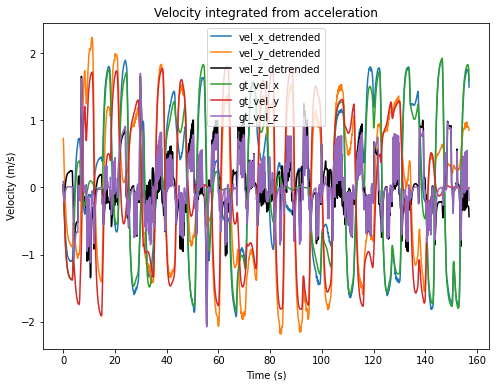

In [12]:
from scipy import signal
plt.figure(figsize=(8,6))
t = train_data["seconds"]
vel_x = integrate.cumtrapz(train_data["S_LIN_ACC_X_world"], t, initial=0)
vel_y = integrate.cumtrapz(train_data["S_LIN_ACC_Y_world"], t, initial=0)
vel_z = integrate.cumtrapz(train_data["S_LIN_ACC_Z_world"], t, initial=0) 
plt.plot(t,signal.detrend(vel_x), label = "vel_x_detrended")
plt.plot(t,signal.detrend(vel_y), label = "vel_y_detrended")
plt.plot(t,signal.detrend(vel_z), label = "vel_z_detrended",color="black")
# plt.plot(t,vel_x, label = "vel_x")
# plt.plot(t,vel_y, label = "vel_y")
# plt.plot(t,vel_z, label = "vel_z")
plt.plot(t,train_data["LIN_VEL_X"], label = "gt_vel_x")
plt.plot(t,train_data["LIN_VEL_Y"], label = "gt_vel_y")
plt.plot(t,train_data["LIN_VEL_Z"], label = "gt_vel_z")
plt.title("Velocity integrated from acceleration")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
# plt.xlim([50, 160])
# plt.grid()
plt.legend()

### Check drift error if naive double integration was used

In [13]:
vel_x = signal.detrend(vel_x)
vel_y = signal.detrend(vel_y)
vel_z = signal.detrend(vel_z)

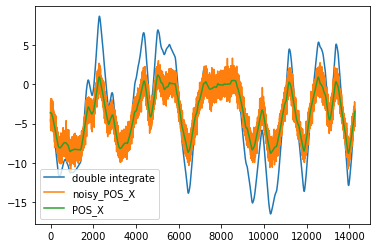

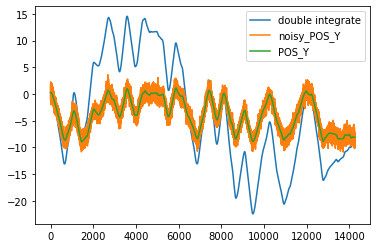

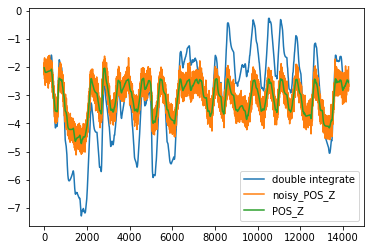

In [14]:
displacement = integrate.cumtrapz(vel_x, t, initial=0)
plt.figure()
plt.plot(displacement + train_data["POS_X"], label = "double integrate")
plt.plot(train_data["noisy_POS_X"], label = "noisy_POS_X")
plt.plot(train_data["POS_X"], label = "POS_X")
plt.legend()

plt.figure()
displacement = integrate.cumtrapz(vel_y, t, initial=0)
plt.plot(displacement + train_data["POS_Y"], label = "double integrate")
plt.plot(train_data["noisy_POS_Y"], label = "noisy_POS_Y")
plt.plot(train_data["POS_Y"], label = "POS_Y")
plt.legend()

plt.figure()
displacement = integrate.cumtrapz(vel_z, t, initial=0)
plt.plot(displacement + train_data["POS_Z"], label = "double integrate")
plt.plot(train_data["noisy_POS_Z"], label = "noisy_POS_Z")
plt.plot(train_data["POS_Z"], label = "POS_Z")
plt.legend()

In [15]:
# Get imu linear velocity integrated using imu acceleration corrected using noisy orientation
train_data["S_LIN_VEL_X"] = vel_x
train_data["S_LIN_VEL_Y"] = vel_y
train_data["S_LIN_VEL_Z"] = vel_z
train_data["prev_S_LIN_VEL_X"] = train_data["S_LIN_VEL_X"].shift(1)
train_data["prev_S_LIN_VEL_Y"] = train_data["S_LIN_VEL_Y"].shift(1)
train_data["prev_S_LIN_VEL_Z"] = train_data["S_LIN_VEL_Z"].shift(1)

train_data["S_LIN_ACC_X"] = train_data["S_LIN_ACC_X_world"]
train_data["S_LIN_ACC_Y"] = train_data["S_LIN_ACC_Y_world"]
train_data["S_LIN_ACC_Z"] = train_data["S_LIN_ACC_Z_world"]
train_data["prev_S_LIN_ACC_X"] = train_data["S_LIN_ACC_X"].shift(1)
train_data["prev_S_LIN_ACC_Y"] = train_data["S_LIN_ACC_Y"].shift(1)
train_data["prev_S_LIN_ACC_Z"] = train_data["S_LIN_ACC_Z"].shift(1)

## Obtaining IMU derived Relative translation

In [16]:
skip = 10
# number of imu readings for each image frame (e.g. if 100Hz IMU and 10Hz Img freq,
# there are 10 imu readings for each image frame)
image_frame_step = 10 
# Gap between frames used in sample (rmb to change the value in 
# MapNet.ini as well, skip = k/image_frame_step = 10)
k  = skip * image_frame_step

#### Just using COLMAP

In [17]:
results = []
for i in range(k, len(train_data), image_frame_step):
    x = train_data.iloc[i, :].noisy_POS_X - train_data.iloc[i - k, :].noisy_POS_X
    y = train_data.iloc[i, :].noisy_POS_Y - train_data.iloc[i - k, :].noisy_POS_Y
    z = train_data.iloc[i, :].noisy_POS_Z - train_data.iloc[i - k, :].noisy_POS_Z

    results.append([x, y, z])

noisy_rel_trans = pd.DataFrame(results, columns=["rel_POS_X", "rel_POS_Y","rel_POS_Z"])
noisy_rel_trans["idx"] = [i for i in range(k, len(train_data), image_frame_step)]
noisy_rel_trans.set_index("idx", inplace=True)

#### Just IMU

In [18]:
results = []
timesteps = []
for i in range(k, len(train_data), image_frame_step):
    x = y = z = 0
    timestep = 0 
    for j in range(i - k + 1, i + 1):
        row = train_data.iloc[j, :]
        x += row.prev_S_LIN_VEL_X * row.timestep + 1/2 * row.prev_S_LIN_ACC_X * row.timestep ** 2 
        y += row.prev_S_LIN_VEL_Y * row.timestep + 1/2 * row.prev_S_LIN_ACC_Y * row.timestep ** 2 
        z += row.prev_S_LIN_VEL_Z * row.timestep + 1/2 * row.prev_S_LIN_ACC_Z * row.timestep ** 2
        timestep += row.timestep
    timesteps.append(timestep)
    results.append([x, y, z])

imu_rel_trans = pd.DataFrame(results, columns=["imu_rel_POS_X", "imu_rel_POS_Y","imu_rel_POS_Z"])
imu_rel_trans["idx"] = [i for i in range(k, len(train_data), image_frame_step)]
imu_rel_trans.set_index("idx", inplace=True)
print(np.mean(timesteps))

1.0999885235398719


In [19]:
# True relative translation
train_data["rel_POS_X"] = train_data["POS_X"] - train_data["POS_X"].shift(k)
train_data["rel_POS_Y"] = train_data["POS_Y"] - train_data["POS_Y"].shift(k)
train_data["rel_POS_Z"] = train_data["POS_Z"] - train_data["POS_Z"].shift(k)

print("Just COLMAP")
err =[]
for i in range(len(noisy_rel_trans)):
    err.append(np.linalg.norm(np.array(noisy_rel_trans[["rel_POS_X", "rel_POS_Y","rel_POS_Z"]].iloc[i,:]) - np.array(train_data[["rel_POS_X", "rel_POS_Y", "rel_POS_Z"]].iloc[k + i * image_frame_step,:])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

print("Just IMU")
err =[]
for i in range(len(imu_rel_trans)):
    err.append(np.linalg.norm(np.array(imu_rel_trans[["imu_rel_POS_X", "imu_rel_POS_Y","imu_rel_POS_Z"]].iloc[i,:]) - np.array(train_data[["rel_POS_X", "rel_POS_Y", "rel_POS_Z"]].iloc[k + i * image_frame_step,:])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

Just COLMAP
Translation error 1.3221130091797952 (median) m, 1.4260626393072058 (mean) m
Just IMU
Translation error 0.5071026719977977 (median) m, 0.5376865145772817 (mean) m


In [37]:
train_data["imu_rel_POS_X"] = imu_rel_trans["imu_rel_POS_X"]
train_data["imu_rel_POS_Y"] = imu_rel_trans["imu_rel_POS_Y"]
train_data["imu_rel_POS_Z"] = imu_rel_trans["imu_rel_POS_Z"]
train_data["imu_POS_X"] = train_data["noisy_POS_X"].shift(k) + train_data["imu_rel_POS_X"]
train_data["imu_POS_Y"] = train_data["noisy_POS_Y"].shift(k) + train_data["imu_rel_POS_Y"]
train_data["imu_POS_Z"] = train_data["noisy_POS_Z"].shift(k) + train_data["imu_rel_POS_Z"]

## Obtain IMU derived Relative Orientation

In [38]:
# Get previous angular velocity
train_data["prev_S_ANG_VEL_X"] = train_data["S_ANG_VEL_X"].shift(1)
train_data["prev_S_ANG_VEL_Y"] = train_data["S_ANG_VEL_Y"].shift(1)
train_data["prev_S_ANG_VEL_Z"] = train_data["S_ANG_VEL_Z"].shift(1)

### AHRS Integration

In [39]:
from ahrs.filters import AngularRate
abs_results = []
rel_results = []
for i in range(k, len(train_data), image_frame_step):
    qw = train_data.iloc[i - k, :].noisy_Q_W
    qx = train_data.iloc[i - k, :].noisy_Q_X
    qy = train_data.iloc[i - k, :].noisy_Q_Y
    qz = train_data.iloc[i - k, :].noisy_Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    cur_q = q_prev
    angular_rate = AngularRate()
    for j in range(i - k + 1, i + 1):
        row = train_data.iloc[j, :]
        cur_q = angular_rate.update(cur_q, 
                                    np.hstack([row["prev_S_ANG_VEL_X"],
                                               row["prev_S_ANG_VEL_Y"], 
                                               row["prev_S_ANG_VEL_Z"]]),
                                    'closed', 
                                    1,
                                    row['timestep'])
        cur_q = rowan.normalize(cur_q)
    rel_q = calc_rel_orientation(q_prev, cur_q)
    abs_results.append(cur_q)
    rel_results.append(rel_q)

In [40]:
imu_q_ahrs = pd.DataFrame(abs_results, columns=["imu_Q_W", "imu_Q_X", "imu_Q_Y", "imu_Q_Z"])
imu_q_ahrs["idx"] = [i for i in range(k, len(train_data), image_frame_step)]
imu_q_ahrs.set_index("idx", inplace=True)

imu_q_ahrs_rel = pd.DataFrame(rel_results, columns=["imu_rel_Q_W", "imu_rel_Q_X", "imu_rel_Q_Y", "imu_rel_Q_Z"])
imu_q_ahrs_rel["idx"] = [i for i in range(k, len(train_data), image_frame_step)]
imu_q_ahrs_rel.set_index("idx", inplace=True)

### Just COLMAP

In [41]:
results = []
for i in range(k, len(train_data), image_frame_step):
    qw = train_data.iloc[i - k, :].noisy_Q_W
    qx = train_data.iloc[i - k, :].noisy_Q_X
    qy = train_data.iloc[i - k, :].noisy_Q_X
    qz = train_data.iloc[i - k, :].noisy_Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    qw = train_data.iloc[i, :].noisy_Q_W
    qx = train_data.iloc[i, :].noisy_Q_X
    qy = train_data.iloc[i, :].noisy_Q_X
    qz = train_data.iloc[i, :].noisy_Q_Z
    q = np.array([qw, qx, qy, qz]) 
    
    results.append(calc_rel_orientation(q_prev, q))
noisy_orient_rel = pd.DataFrame(results, columns=["rel_Q_W", "rel_Q_X", "rel_Q_Y", "rel_Q_Z"])
noisy_orient_rel["idx"] = [i for i in range(k, len(train_data), image_frame_step)]
noisy_orient_rel.set_index("idx", inplace=True)

In [42]:
# True Relative orientation
true_rel_orientation = []
for i in range(k, len(train_data), image_frame_step):
    qw = train_data.iloc[i - k, :].Q_W
    qx = train_data.iloc[i - k, :].Q_X
    qy = train_data.iloc[i - k, :].Q_X
    qz = train_data.iloc[i - k, :].Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    qw = train_data.iloc[i, :].Q_W
    qx = train_data.iloc[i, :].Q_X
    qy = train_data.iloc[i, :].Q_X
    qz = train_data.iloc[i, :].Q_Z
    q = np.array([qw, qx, qy, qz]) 
    
    true_rel_orientation.append(calc_rel_orientation(q_prev, q))
true_rel = pd.DataFrame(true_rel_orientation, columns=["true_rel_Q_W", "true_rel_Q_X", "true_rel_Q_Y", "true_rel_Q_Z"])
true_rel["idx"] = [i for i in range(k, len(train_data), image_frame_step)]
true_rel.set_index("idx", inplace=True)

In [43]:
print("Just COLMAP")
axis_angle_err =[]
for i in range(len(imu_q_ahrs_rel)):
    axis_angle_err.append(
        calc_quat_angle_error_single(noisy_orient_rel[["rel_Q_W", "rel_Q_X", "rel_Q_Y", "rel_Q_Z"]].iloc[i,:],
                                    true_rel[["true_rel_Q_W", "true_rel_Q_X", "true_rel_Q_Y", "true_rel_Q_Z"]].iloc[i,:])
    )
print(f'Orientation error {np.median(axis_angle_err)} (median) deg, {np.mean(axis_angle_err)} (mean) deg')

print("AHRS")
axis_angle_err =[]
for i in range(len(imu_q_ahrs_rel)):
    axis_angle_err.append(
        calc_quat_angle_error_single(imu_q_ahrs_rel[["imu_rel_Q_W", "imu_rel_Q_X", "imu_rel_Q_Y", "imu_rel_Q_Z"]].iloc[i,:],
                                    true_rel[["true_rel_Q_W", "true_rel_Q_X", "true_rel_Q_Y", "true_rel_Q_Z"]].iloc[i,:])
    )
print(f'Orientation error {np.median(axis_angle_err)} (median) deg, {np.mean(axis_angle_err)} (mean) deg')

Just COLMAP
Orientation error 11.598978677198268 (median) deg, 12.467826210736746 (mean) deg
AHRS
Orientation error 3.1315796596977465 (median) deg, 4.73768406524039 (mean) deg


In [44]:
train_data["imu_Q_W"] = imu_q_ahrs["imu_Q_W"]
train_data["imu_Q_X"] = imu_q_ahrs["imu_Q_Y"]
train_data["imu_Q_Y"] = imu_q_ahrs["imu_Q_X"]
train_data["imu_Q_Z"] = imu_q_ahrs["imu_Q_Z"]

## Distribution of relative poses

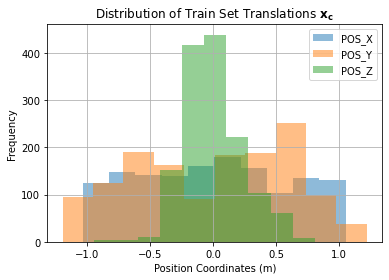

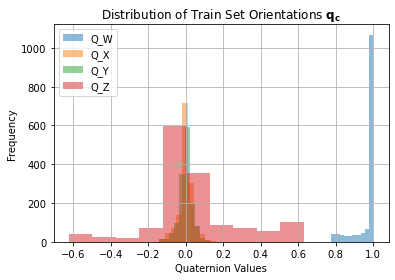

In [45]:
%matplotlib inline
plt.figure()
plt.hist(imu_rel_trans["imu_rel_POS_X"], label="POS_X", alpha=0.5)
plt.hist(imu_rel_trans["imu_rel_POS_Y"], label="POS_Y", alpha=0.5)
plt.hist(imu_rel_trans["imu_rel_POS_Z"], label="POS_Z", alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("Position Coordinates (m)")
plt.title('Distribution of Train Set Translations ' + r'$\bf{x}_c$')
plt.legend()
plt.grid()

plt.figure()
plt.hist(imu_q_ahrs_rel["imu_rel_Q_W"], label="Q_W", alpha=0.5)
plt.hist(imu_q_ahrs_rel["imu_rel_Q_X"], label="Q_X", alpha=0.5)
plt.hist(imu_q_ahrs_rel["imu_rel_Q_Y"], label="Q_Y", alpha=0.5)
plt.hist(imu_q_ahrs_rel["imu_rel_Q_Z"], label="Q_Z", alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("Quaternion Values")
plt.title('Distribution of Train Set Orientations ' + r'$\bf{q}_c$')
plt.legend()
plt.grid()

## Write to file

In [46]:
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)  

In [47]:
final_write_file = train_data.iloc[::image_frame_step,:]
final_write_file = final_write_file[["ImageFile", "timestep", 
                               "noisy_POS_X", "noisy_POS_Y", "noisy_POS_Z", "noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z",
                               "imu_POS_X", "imu_POS_Y", "imu_POS_Z", "imu_Q_W", "imu_Q_X","imu_Q_Y","imu_Q_Z"
                              ]]
final_write_file.reset_index(drop=True, inplace =True)
final_write_file.rename(columns = {'noisy_POS_X':'POS_X', 
                                   'noisy_POS_Y':'POS_Y',
                                   'noisy_POS_Z':'POS_Z',
                                   'noisy_Q_W':'Q_W',
                                   'noisy_Q_X':'Q_X',
                                   'noisy_Q_Y':'Q_Y',
                                   'noisy_Q_Z':'Q_Z' }, 
                        inplace = True)


In [48]:
final_write_file.loc[0:skip-1,'imu_POS_Y'] = final_write_file.loc[0:skip-1,'POS_Y']
final_write_file.loc[0:skip-1,'imu_POS_Z'] = final_write_file.loc[0:skip-1,'POS_Z']
final_write_file.loc[0:skip-1,'imu_POS_X'] = final_write_file.loc[0:skip-1,'POS_X']
final_write_file.loc[0:skip-1,'imu_Q_W'] = final_write_file.loc[0:skip-1,'Q_W']
final_write_file.loc[0:skip-1,'imu_Q_X'] = final_write_file.loc[0:skip-1,'Q_X']
final_write_file.loc[0:skip-1,'imu_Q_Y'] = final_write_file.loc[0:skip-1,'Q_Y']
final_write_file.loc[0:skip-1,'imu_Q_Z'] = final_write_file.loc[0:skip-1,'Q_Z']
final_write_file.loc[0,'timestep'] = 0.0

In [49]:
final_write_file.to_csv('D:/Imperial/FYP/captured_data/airsim_drone_mode/building_new/train/check_v2.txt', 
                        header=True, 
                        index=None, 
                        sep=' ', 
                        mode='w')